![<image title>](http://link.com/to/image.png "image alt text")

---

# Using intake-esgf with rooki
Here we dig into using intake-esgf to search for data, then rooki to do server-side computing!

---

## Overview
If you have an introductory paragraph, lead with it here! Keep it short and tied to your material, then be sure to continue into the required list of topics below,

1. This is a numbered list of the specific topics
1. These should map approximately to your main sections of content
1. Or each second-level, `##`, header in your notebook
1. Keep the size and scope of your notebook in check
1. And be sure to let the reader know up front the important concepts they'll be leaving with

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports

In [4]:
import os

from rooki import rooki
from intake_esgf import ESGFCatalog
import xarray as xr

In [5]:
def separate_dataset_id(full_dataset):
    return full_dataset[0].split("|")[0]

In [6]:
cat = ESGFCatalog()
cat.search(
        activity_id='CMIP',
        experiment_id=["historical",],
        variable_id=["tas"],
        member_id='r1i1p1f1',
        grid_label='gn',
        table_id="Amon",
        source_id = [ "CMCC-ESM2", "CanESM5", "CESM2", "CESM2-FV2", ]
    )

dsets = [separate_dataset_id(dataset) for dataset in list(cat.df.id.values)]
dsets

   Searching indices:   0%|          |0/2 [       ?index/s]

['CMIP6.CMIP.NCAR.CESM2.historical.r1i1p1f1.Amon.tas.gn.v20190308',
 'CMIP6.CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1.Amon.tas.gn.v20210114',
 'CMIP6.CMIP.NCAR.CESM2-FV2.historical.r1i1p1f1.Amon.tas.gn.v20191120',
 'CMIP6.CMIP.CCCma.CanESM5.historical.r1i1p1f1.Amon.tas.gn.v20190429']

In [7]:
def query_compute_data(dset_id):
    resp = rooki.subset(
        collection=dset,
        time='1900-01-01/2000-01-31',
        area='65,0,100,35',
    )
    
    if resp.ok:
        ds = resp.datasets()[0]
    else:
        ds = xr.Dataset()
        
    return ds


In [15]:
from rooki import operators as ops

In [20]:
ops.AverageByTime?

Init signature: ops.AverageByTime(*args, **kwargs)
Docstring:      <no docstring>
File:           ~/mambaforge/envs/esgf-cookbook-dev/lib/python3.10/site-packages/rooki/operators.py
Type:           type
Subclasses:     

In [24]:
wf = ops.Input('tas', dsets[0])

In [35]:
ops.AverageByTime??

Init signature: ops.AverageByTime(*args, **kwargs)
Docstring:      <no docstring>
Source:        
class AverageByTime(Operator):
    METHOD = "average_time"
File:           ~/mambaforge/envs/esgf-cookbook-dev/lib/python3.10/site-packages/rooki/operators.py
Type:           type
Subclasses:     

In [59]:
def compute_annual_mean_subset(dset_id):
    # Subset by area then time
    wf = ops.AverageByTime(
        ops.Subset(
            ops.Input(
                'tas', [dsets[0]]
            ),
            time='1900-01-01/2000-12-31',
            area='65,0,100,35',
        ),
    freq="year"
    )
    
    resp = wf.orchestrate()
    
    if resp.ok:
        ds = resp.datasets()[0]
    else:
        ds = xr.Dataset()
    return ds

In [60]:
dset_dict = {}
for dset in dsets:
    dset_dict[dset] = compute_annual_mean_subset(dset)

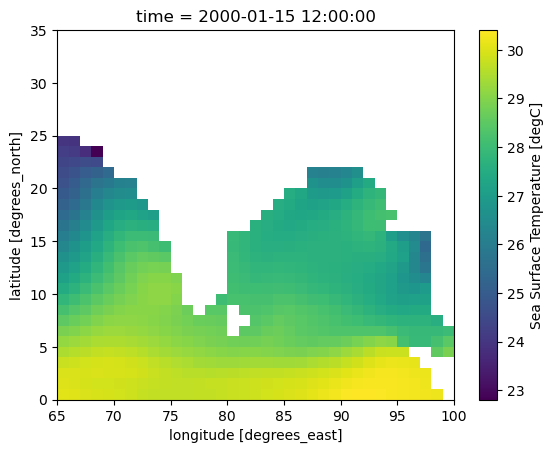

In [30]:
ds.tos.isel(time=0).plot()